# Node embeddings
Снова посмотрим на реальный граф [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club), показывающий кто из учеников общается вне занятий. После конфликта администратора и инструктора такой граф был использован для разделения учеников на два новых клуба.

In [1]:
import networkx as nx

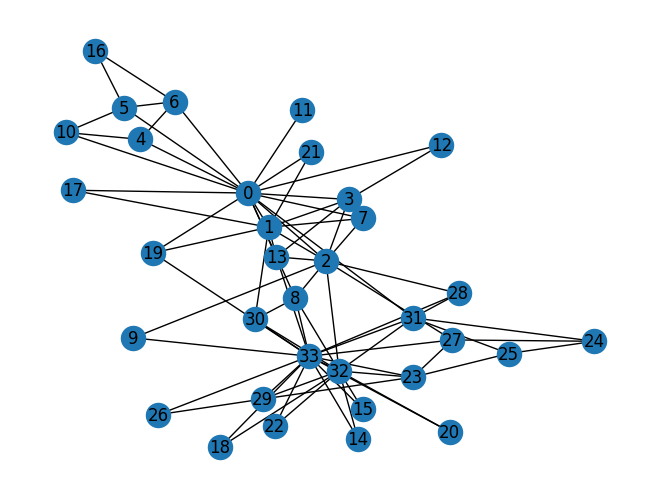

In [2]:
G = nx.karate_club_graph()
# Visualize the graph
nx.draw(G, with_labels = True)

# 2 Graph to Tensor
Представим список рёбер графа $G$ в виде PyTorch tensor.

In [3]:
import torch

def graph_to_edge_list(G):

  return list(G.edges())

def edge_list_to_tensor(edge_list):
  # The function that transforms the edge_list to
  # tensor. The input edge_list is a list of tuples and the resulting
  # tensor should have the shape [2, len(edge_list)].

  edge_index = torch.tensor(edge_list, dtype=torch.long).permute((1, 0))

  return edge_index

pos_edge_list = graph_to_edge_list(G)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
print("The pos_edge_index tensor has shape {}".format(pos_edge_index.shape))
print("The pos_edge_index tensor has sum value {}".format(torch.sum(pos_edge_index)))

The pos_edge_index tensor has shape torch.Size([2, 78])
The pos_edge_index tensor has sum value 2535


## Negative sampling

"Negative" edges --- рёбра, которых нету в графе. Например, ребро (src, dst) отрицательное, если ни (src, dst), ни (dst, src) не являются рёбрами графа.

In [4]:
import numpy as np

def sample_negative_edges(G, num_neg_samples):
  # Returns a list of negative edges.
  # The number of sampled negative edges is num_neg_samples.
  # In this implementation, self loops should
  # not be considered as either a positive or negative edge. Also, notice that
  # the karate club network is an undirected graph, if (0, 1) is a positive
  # edge then (1, 0) is also a positive edge.

  neg_edge_list = []

  pos_set = set(G.edges())

  while len(neg_edge_list) < num_neg_samples:
    random_pair = np.random.choice(G.nodes(), 2)
    u = random_pair[0]
    v = random_pair[1]
    if u == v or (u, v) in pos_set or (v, u) in pos_set:
      continue
    if (u, v) in neg_edge_list or (v, u) in neg_edge_list:
      continue
    neg_edge_list.append((u, v))
    #print(u, v)

  return neg_edge_list

np.random.seed(20)

# Sample 78 negative edges
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# Transform the negative edge list to tensor
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("The neg_edge_index tensor has shape {}".format(neg_edge_index.shape))

The neg_edge_index tensor has shape torch.Size([2, 78])


# 3 Node Emebedding Learning

Обучим модель классификации рёбер, основанную на эмбеддингах вершин.


## Setup

In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Воспользуемся модулем [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html).

In [6]:
# Initialize an embedding layer
# Suppose we want to have embedding for 4 items (e.g., nodes)
# Each item is represented with 8 dimensional vector

emb_sample = nn.Embedding(num_embeddings=4, embedding_dim=8)
print('Sample embedding layer: {}'.format(emb_sample))

Sample embedding layer: Embedding(4, 8)


Доступ к элементам у матрицы эмбеддингов такой же как у тензоров.

In [7]:
# Select an embedding in emb_sample
id = torch.LongTensor([1])
print(emb_sample(id))

# Select multiple embeddings
ids = torch.LongTensor([1, 3])
print(emb_sample(ids))

# Get the shape of the embedding weight matrix
shape = emb_sample.weight.data.shape
print(shape)

# Overwrite the weight to tensor with all ones
emb_sample.weight.data = torch.ones(shape)

# Let's check if the emb is indeed initilized
ids = torch.LongTensor([0, 3])
print(emb_sample(ids))

tensor([[-2.0242, -0.3828,  0.4166, -0.0118, -0.4024, -0.2466,  0.2934,  0.0809]],
       grad_fn=<EmbeddingBackward0>)
tensor([[-2.0242, -0.3828,  0.4166, -0.0118, -0.4024, -0.2466,  0.2934,  0.0809],
        [-1.3563, -1.7373,  0.8385,  0.1014, -1.4777,  0.0166, -0.7737, -0.5482]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([4, 8])
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<EmbeddingBackward0>)


Создадим новую матрицу эмбеддингов.
- Пусть размерность будет **16** для каждой вершины графа.
- Инициализируем из равномерного распределения $[0, 1)$.

In [8]:
torch.manual_seed(12)

def create_node_emb(num_node=34, embedding_dim=16):
  # Сreate the node embedding matrix.
  # A torch.nn.Embedding layer will be returned.

  emb = torch.nn.Embedding(num_embeddings=num_node, embedding_dim=embedding_dim)

  return emb

emb = create_node_emb()
ids = torch.LongTensor([0, 3])

# Print the embedding layer
print("Embedding: {}".format(emb))

# An example that gets the embeddings for node 0 and 3
print(emb(ids))

Embedding: Embedding(34, 16)
tensor([[-0.1320, -0.1254,  0.3443, -0.4519, -0.8888, -0.3526, -1.3373,  0.5223,
         -1.1118, -0.7171,  1.0426, -1.2510, -0.5107, -0.3843, -0.4899,  0.5306],
        [ 0.5993,  2.2986, -0.8951, -2.7441,  0.9802,  1.8197,  1.4824,  0.0126,
          0.6731, -0.9022, -1.9099, -0.9995, -1.0266,  0.9739, -1.8436, -0.4994]],
       grad_fn=<EmbeddingBackward0>)


## Visualize the initial node embeddings
Для визуализации пространства эмбеддингов снизим их размерность до 2 с помощью PCA и расскрасим двумя цветами (кто пошел в какой из двух клубов).

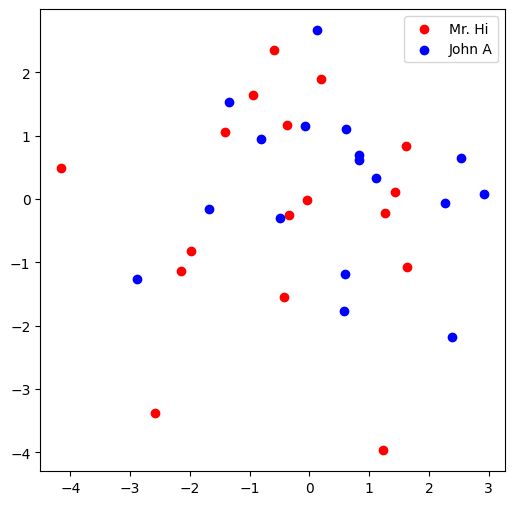

In [9]:
def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []
  for node in G.nodes(data=True):
    if node[1]['club'] == 'Mr. Hi':
      club1_x.append(components[node[0]][0])
      club1_y.append(components[node[0]][1])
    else:
      club2_x.append(components[node[0]][0])
      club2_y.append(components[node[0]][1])
  plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
  plt.scatter(club2_x, club2_y, color="blue", label="John A")
  plt.legend()
  plt.show()

# Visualize the initial random embeddding
visualize_emb(emb)

Видим что сейчас эмбеддинги вершин плохо отражают схожость вершин в графе (кто с кем общается вне занятий). Оно и понятно, ведь пока что эмбеддинги случайные, не обученнные.

## Training the embedding

Оптимизируем эмбеддинги для задачи классификации рёбер как позитивных или негативных (для этого графа получается предсказываем общаются ли два ученика вне занятий).

Скалярное произведение эмбеддингов двух вершин взятое под сигмоиду должно давать нам предсказание ребро позитивное (sigmoid > 0.5) или негативное (sigmoid < 0.5).

torch.Size([2, 78])
torch.Size([2, 156])


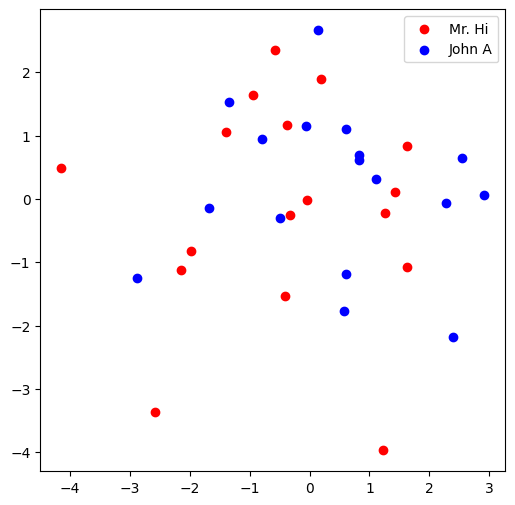

1.521759033203125 0.4744
1.5121233463287354 0.4744
1.493980884552002 0.4744
1.4683761596679688 0.4872
1.4363174438476562 0.4872
1.3988456726074219 0.4872
1.3568729162216187 0.4872
1.3113057613372803 0.4872
1.2629642486572266 0.4872
1.2126109600067139 0.4872
1.1609786748886108 0.5192
1.1086974143981934 0.5321
1.0563552379608154 0.5513
1.0044766664505005 0.5641
0.953528881072998 0.5833
0.9038856625556946 0.5897
0.8558650612831116 0.6026
0.8097145557403564 0.6218
0.7656090259552002 0.6346
0.7236647009849548 0.6731
0.6839528679847717 0.6859
0.6465005874633789 0.6987
0.6112997531890869 0.7244
0.5783181190490723 0.7628
0.5474920272827148 0.7821
0.5187381505966187 0.8077
0.49195390939712524 0.8141
0.46702462434768677 0.8141
0.4438265264034271 0.8205
0.42223474383354187 0.8205
0.4021259844303131 0.8462
0.3833828568458557 0.859
0.3658948540687561 0.8654
0.34955939650535583 0.8846
0.3342822790145874 0.8846
0.31997743248939514 0.9038
0.3065663278102875 0.9167
0.29397767782211304 0.9231
0.28214713

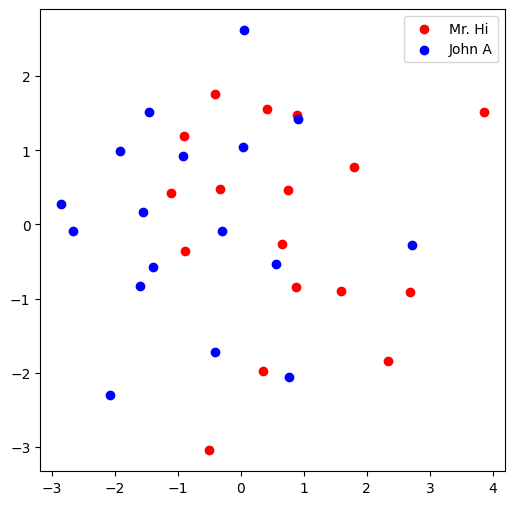

0.18365401029586792 0.9615
0.17820076644420624 0.9679
0.1730649173259735 0.9679
0.1682243049144745 0.9679
0.16365750133991241 0.9679
0.15934418141841888 0.9679
0.1552654355764389 0.9679
0.15140387415885925 0.9744
0.1477435827255249 0.9744
0.14427010715007782 0.9744
0.14097023010253906 0.9744
0.13783176243305206 0.9744
0.13484345376491547 0.9744
0.13199485838413239 0.9744
0.12927618622779846 0.9808
0.12667839229106903 0.9936
0.12419288605451584 0.9936
0.12181179225444794 0.9936
0.11952774226665497 0.9936
0.11733397096395493 0.9936
0.11522417515516281 0.9936
0.11319269239902496 0.9936
0.11123426258563995 0.9936
0.10934415459632874 0.9936
0.1075180247426033 0.9936
0.10575199127197266 0.9936
0.10404247790575027 0.9936
0.10238626599311829 0.9936
0.1007804349064827 0.9936
0.09922230243682861 0.9936
0.09770943969488144 0.9936
0.0962396189570427 0.9936
0.09481080621480942 0.9936
0.09342111647129059 0.9936
0.09206879138946533 0.9936
0.0907522439956665 0.9936
0.08946994692087173 1.0
0.0882205218

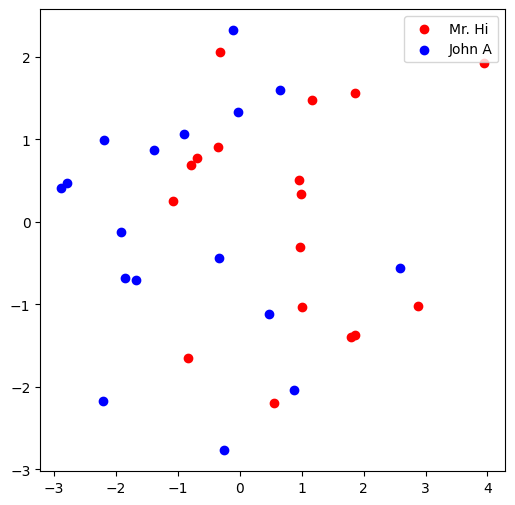

0.07446113973855972 1.0
0.07356223464012146 1.0
0.07268243283033371 1.0
0.07182112336158752 1.0
0.07097773253917694 1.0
0.07015169411897659 1.0
0.0693424791097641 1.0
0.06854958087205887 1.0
0.0677725076675415 1.0
0.067010797560215 1.0
0.06626398116350174 1.0
0.0655316412448883 1.0
0.06481336057186127 1.0
0.06410872936248779 1.0
0.06341738253831863 1.0
0.06273893266916275 1.0
0.06207304075360298 1.0
0.06141936033964157 1.0
0.060777559876441956 1.0
0.060147326439619064 1.0
0.059528376907110214 1.0
0.05892038345336914 1.0
0.05832308530807495 1.0
0.05773618817329407 1.0
0.057159461081027985 1.0
0.05659262835979462 1.0
0.05603545904159546 1.0
0.055487699806690216 1.0
0.054949142038822174 1.0
0.05441954731941223 1.0
0.05389871820807457 1.0
0.05338643118739128 1.0
0.05288249999284744 1.0
0.05238671973347664 1.0
0.05189891532063484 1.0
0.05141889303922653 1.0
0.05094648152589798 1.0
0.05048151686787605 1.0
0.05002381280064583 1.0
0.04957323893904686 1.0
0.049129609018564224 1.0
0.048692800104

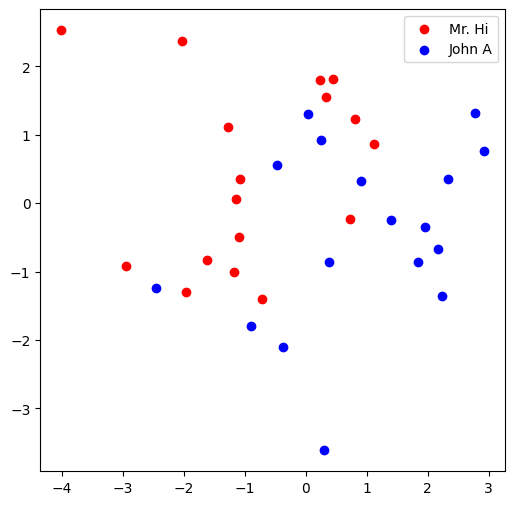

0.045044831931591034 1.0
0.04466864839196205 1.0
0.04429785907268524 1.0
0.04393235966563225 1.0
0.04357205331325531 1.0
0.04321682080626488 1.0
0.04286657273769379 1.0
0.04252120107412338 1.0
0.0421806275844574 1.0
0.04184475168585777 1.0
0.04151347652077675 1.0
0.04118671640753746 1.0
0.04086439311504364 1.0
0.04054642468690872 1.0
0.040232717990875244 1.0
0.03992319107055664 1.0
0.039617784321308136 1.0
0.03931640461087227 1.0
0.039018984884023666 1.0
0.03872545436024666 1.0
0.03843573480844498 1.0
0.03814976289868355 1.0
0.037867471575737 1.0
0.037588801234960556 1.0
0.03731366619467735 1.0
0.037042029201984406 1.0
0.03677380830049515 1.0
0.036508958786726 1.0
0.036247409880161285 1.0
0.03598910942673683 1.0
0.03573400527238846 1.0
0.035482026636600494 1.0
0.03523314371705055 1.0
0.03498728945851326 1.0
0.03474440798163414 1.0
0.03450445830821991 1.0
0.03426738828420639 1.0
0.03403315320611 1.0
0.03380170091986656 1.0
0.03357298672199249 1.0
0.033346958458423615 1.0
0.0331235863268

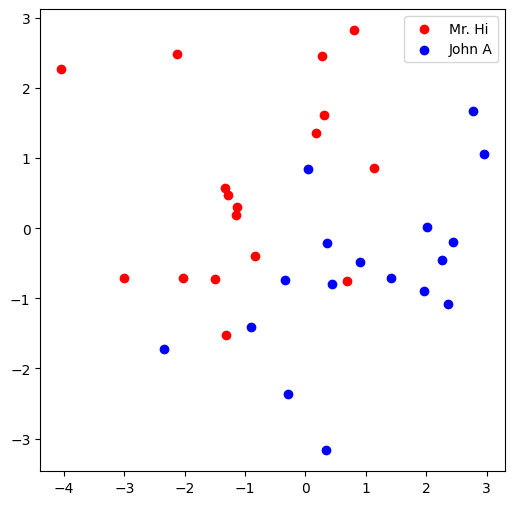

0.031225576996803284 1.0
0.03102644346654415 1.0
0.03082953952252865 1.0
0.030634818598628044 1.0
0.030442241579294205 1.0
0.030251789838075638 1.0
0.03006342053413391 1.0
0.02987710013985634 1.0
0.02969280257821083 1.0
0.0295105017721653 1.0
0.02933015488088131 1.0
0.029151735827326775 1.0
0.02897522784769535 1.0
0.028800591826438904 1.0
0.0286277923732996 1.0
0.028456825762987137 1.0
0.02828763984143734 1.0
0.028120221570134163 1.0
0.027954544872045517 1.0
0.027790583670139313 1.0
0.02762831188738346 1.0
0.02746770717203617 1.0
0.027308739721775055 1.0
0.02715139277279377 1.0
0.026995640248060226 1.0
0.02684144861996174 1.0
0.026688817888498306 1.0
0.026537708938121796 1.0
0.02638811245560646 1.0
0.02624000422656536 1.0
0.02609334886074066 1.0
0.02594814822077751 1.0
0.025804370641708374 1.0
0.02566199190914631 1.0
0.02552100084722042 1.0
0.025381378829479218 1.0
0.02524310164153576 1.0
0.02510615438222885 1.0
0.02497052773833275 1.0
0.024836178869009018 1.0
0.024703117087483406 1.0


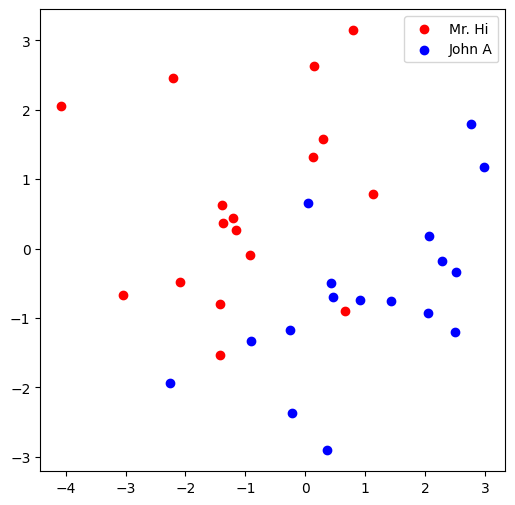

0.02343907207250595 1.0
0.023318985477089882 1.0
0.023199988529086113 1.0
0.02308207005262375 1.0
0.022965218871831894 1.0
0.02284940332174301 1.0
0.0227346271276474 1.0
0.022620877251029015 1.0
0.022508131340146065 1.0
0.02239638939499855 1.0
0.02228562906384468 1.0
0.022175844758749008 1.0
0.022067008540034294 1.0
0.021959127858281136 1.0
0.02185218408703804 1.0
0.02174617163836956 1.0
0.021641060709953308 1.0
0.02153686247766018 1.0
0.021433552727103233 1.0
0.021331120282411575 1.0
0.021229567006230354 1.0
0.02112887054681778 1.0
0.021029023453593254 1.0
0.020930010825395584 1.0
0.020831827074289322 1.0
0.02073446847498417 1.0
0.020637918263673782 1.0
0.020542174577713013 1.0
0.02044721134006977 1.0
0.020353039726614952 1.0
0.020259639248251915 1.0
0.020167002454400063 1.0
0.020075112581253052 1.0
0.01998397521674633 1.0
0.019893579185009003 1.0
0.019803903996944427 1.0
0.019714955240488052 1.0
0.019626719877123833 1.0
0.019539188593626022 1.0
0.019452353939414024 1.0
0.019366206601

In [10]:
from torch.optim import SGD
import torch.nn as nn

def accuracy(pred, label):
  # This function takes the pred tensor (the resulting tensor after sigmoid)
  # and the label tensor (torch.LongTensor). Predicted value greater than 0.5
  # will be classified as label 1. Else it will be classified as label 0.
  # The returned accuracy is rounded to 4 decimal places.

  accu = round(((torch.round(pred) == label).sum()/label.size(0)).item(), 4)

  return accu

def train(emb, loss_fn, sigmoid, train_label, train_edge):
  # Train the embedding layer:
  # (1) Get the embeddings of the nodes in train_edge
  # (2) Dot product the embeddings between each node pair
  # (3) Feed the dot product result into sigmoid
  # (4) Feed the sigmoid output into the loss_fn
  # (5) Print both loss and accuracy of each epoch
  # (6) Update the embeddings using the loss and optimizer
  # (as a sanity check, the loss should decrease during training)
  # You can also change epochs and learning rate

  epochs = 300
  learning_rate = 0.1

  optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

  for i in range(epochs):
    optimizer.zero_grad()

    product = torch.sum(torch.mul(emb(train_edge[0]), emb(train_edge[1])), axis=1)
    pred = torch.sigmoid(product)
    loss = loss_fn(pred, train_label)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      acc = accuracy(pred, train_label)
      if i % 50 == 0:
        visualize_emb(emb)
      print(loss.item(), acc)

loss_fn = nn.BCELoss()
sigmoid = nn.Sigmoid()

print(pos_edge_index.shape)

# Generate the positive and negative labels
pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )

# Concat positive and negative labels into one tensor
train_label = torch.cat([pos_label, neg_label], dim=0)

# Concat positive and negative edges into one tensor
# Since the network is very small, we do not split the edges into val/test sets
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)
print(train_edge.shape)

train(emb, loss_fn, sigmoid, train_label, train_edge)

## Visualize the final node embeddings
Можем увидеть, что теперь эмбеддинги довольно хорошо разделяют два класса.

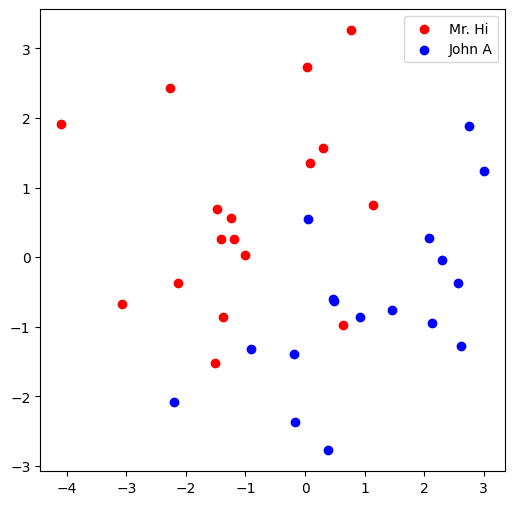

In [11]:
# Visualize the final learned embedding
visualize_emb(emb)